# Building a Basic Image Classifier

In [1]:
import torch
from torchvision import datasets
datapath = "./data/cifar10/"
cifar10 = datasets.CIFAR10(datapath, train=True, download=True)
cifar10_val = datasets.CIFAR10(datapath, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


## Examine what a Torch Dataset object consists of

In [2]:
', '.join([attr for attr in cifar10.__dir__()])

'root, transform, target_transform, transforms, train, data, targets, classes, class_to_idx, __module__, __doc__, base_folder, url, filename, tgz_md5, train_list, test_list, meta, __init__, _load_meta, __getitem__, __len__, _check_integrity, download, extra_repr, __parameters__, _repr_indent, __repr__, _format_transform_repr, __add__, __orig_bases__, __dict__, __weakref__, __slots__, _is_protocol, __new__, __class_getitem__, __init_subclass__, __hash__, __str__, __getattribute__, __setattr__, __delattr__, __lt__, __le__, __eq__, __ne__, __gt__, __ge__, __reduce_ex__, __reduce__, __subclasshook__, __format__, __sizeof__, __dir__, __class__'

In [3]:
cifar10.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [4]:
idx_to_class = {cifar10.class_to_idx[idx]: idx for idx in cifar10.class_to_idx}
[idx_to_class[target] for target in cifar10.targets]

['frog',
 'truck',
 'truck',
 'deer',
 'automobile',
 'automobile',
 'bird',
 'horse',
 'ship',
 'cat',
 'deer',
 'horse',
 'horse',
 'bird',
 'truck',
 'truck',
 'truck',
 'cat',
 'bird',
 'frog',
 'deer',
 'cat',
 'frog',
 'frog',
 'bird',
 'frog',
 'cat',
 'dog',
 'deer',
 'airplane',
 'airplane',
 'truck',
 'automobile',
 'cat',
 'deer',
 'airplane',
 'cat',
 'horse',
 'cat',
 'cat',
 'dog',
 'bird',
 'bird',
 'horse',
 'automobile',
 'automobile',
 'automobile',
 'bird',
 'bird',
 'airplane',
 'truck',
 'dog',
 'horse',
 'truck',
 'bird',
 'bird',
 'dog',
 'bird',
 'deer',
 'cat',
 'automobile',
 'automobile',
 'ship',
 'bird',
 'automobile',
 'automobile',
 'deer',
 'truck',
 'horse',
 'ship',
 'dog',
 'truck',
 'frog',
 'horse',
 'cat',
 'automobile',
 'truck',
 'airplane',
 'cat',
 'automobile',
 'cat',
 'dog',
 'deer',
 'dog',
 'horse',
 'horse',
 'deer',
 'horse',
 'truck',
 'deer',
 'bird',
 'cat',
 'ship',
 'airplane',
 'automobile',
 'frog',
 'automobile',
 'automobile',
 

## Display one of the images for sanity check

1: automobile


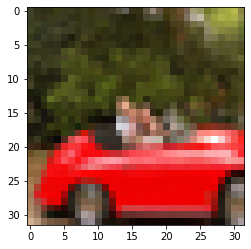

In [5]:
import matplotlib.pyplot as plt

img, label = cifar10[99]
plt.imshow(img)
print(f"{label}: {idx_to_class[label]}")

## But for image classification, we need a tensor represenation (C x H x W layout) of the image data. We'll apply a transform across the whole dataset for this.

In [6]:
from torchvision import transforms

to_tensor = transforms.ToTensor()
tensor_cifar10 = datasets.CIFAR10(datapath, train=True, download=True, transform = to_tensor)
img_tensor, label = tensor_cifar10[99]
img_tensor.shape

Files already downloaded and verified


torch.Size([3, 32, 32])

## It's also important that our NN inputs are scaled to [0, 1]; transforms.ToTensor() should've already taken care of this, but let's verify.

In [7]:
img_tensor.min(), img_tensor.max()

(tensor(0.), tensor(1.))

## For the sake of practice, let's standardize instead of normalize our data. This is a little confusing, as Torch's Normalize function is actually for standardizing, but the terminology is a little loose across disciplines.

In [8]:
all_imgs = torch.stack([img_tensor for img_tensor, _ in tensor_cifar10], dim=3)
all_imgs.shape

torch.Size([3, 32, 32, 50000])

In [9]:
# Compute the mean, std for each different RGB channel.
mean = all_imgs.view(3, -1).mean(dim=1)
std = all_imgs.view(3, -1).std(dim=1)
mean, std

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))

In [10]:
transform_pipeline = transforms.Compose([
    to_tensor,
    transforms.Normalize(mean, std)
])

transformed_cifar10 = datasets.CIFAR10(datapath, train=True, download=True, transform = transform_pipeline)

Files already downloaded and verified


## But what has this transformation _actually_ done to our image represenation?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


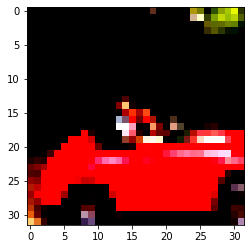

In [11]:
img_t, _ = transformed_cifar10[99]
plt.imshow(img_t.permute(1, 2, 0))

#### Since we standardized instead of normalized to [0, 1], RGB data falling outside the range of [0, 1] gets clipped by matplotlib, hence the black portions in the image. All of our data still exists within the tensor, however.

## Next, let's build a binary classifier that can distinguish birds from planes. These are two of the existing labels in CIFAR10.

In [12]:
label_map = {0: 0, 2: 1} # convert CIFAR10 labels for our own purposes.
class_names = [idx_to_class[label] for label in label_map.keys()]
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

#### Note that the above is a bit of a hack; cifar2 is a simple list of tuples, whereas cifar10 is a torch Dataset class. In a production setting, it's probably worth subclassing Dataset for better Torch integration.

## On to a naive deep model. We'll start out with the (somewhat silly) assumption that each pixel is unrelated; i.e., no convolutions. Each pixel will be its own feature vector.

In [13]:
import torch.nn as nn

input_dim = img_t.reshape(-1, 1).shape[0]
output_dim = len(label_map)

hidden_dim = 512

model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.Tanh(),
    nn.Linear(hidden_dim, output_dim),
    nn.Softmax(dim=1))
model

Sequential(
  (0): Linear(in_features=3072, out_features=512, bias=True)
  (1): Tanh()
  (2): Linear(in_features=512, out_features=2, bias=True)
  (3): Softmax(dim=1)
)

### Let's try running the model before any training, just to see what happens. First, let's take an image from our dataset:

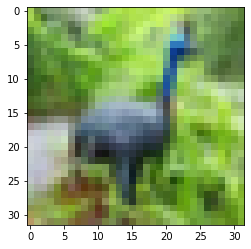

In [14]:
img, _ = cifar2[0]
plt.imshow(img)
plt.show()

In [15]:
dummy_img_test = transform_pipeline(img)
print(f"Before reshape: {dummy_img_test.shape}")
img_test = dummy_img_test.reshape(1, -1)
print(f"After reshape: {img_test.shape}")

Before reshape: torch.Size([3, 32, 32])
After reshape: torch.Size([1, 3072])


In [16]:
untrained_output = model(img_test)
untrained_output

tensor([[0.4895, 0.5105]], grad_fn=<SoftmaxBackward>)

## The above is quite meaningless. Two probabilities (in the sense that the values sum to 1 and are non-negative) that don't correspond to classes. Next step is to actually train the model.

## First, let's glance at how our negative-log-likelihood gets computed.

In [17]:
loss = nn.NLLLoss()

model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.Tanh(),
    nn.Linear(hidden_dim, output_dim),
    nn.LogSoftmax(dim=1))

img, label = cifar2[0]
output = model(transform_pipeline(img).reshape(1, -1))
loss(output, torch.tensor([label]))

tensor(0.9713, grad_fn=<NllLossBackward>)

## Now on to the training (finally):

In [18]:
transformed_cifar10 = datasets.CIFAR10(datapath, train=True, download=True, transform = transform_pipeline)
transformed_cifar10_val = datasets.CIFAR10(datapath, train=False, download=True, transform = transform_pipeline)

cifar2 = [(img, label_map[label])
          for img, label in transformed_cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in transformed_cifar10_val
              if label in [0, 2]]

Files already downloaded and verified
Files already downloaded and verified


In [19]:
train_loader = torch.utils.data.DataLoader(
    cifar2, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    cifar2_val, batch_size=64, shuffle=True)

lr = 1e-2
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.NLLLoss()
n_epochs = 100


def train_model(model, loss_fn, optimizer, n_epochs):
    for epoch in range(n_epochs):
        for imgs, labels in train_loader:
            batch_size = imgs.shape[0]
            outputs = model(imgs.reshape(batch_size, -1))
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch}. Loss {loss}")
train_model(model, loss_fn, optimizer, n_epochs)

Epoch 9. Loss 0.5566878914833069
Epoch 19. Loss 0.18045447766780853
Epoch 29. Loss 0.11467021703720093
Epoch 39. Loss 0.05060455948114395
Epoch 49. Loss 0.07783043384552002
Epoch 59. Loss 0.12021815031766891
Epoch 69. Loss 0.06101994961500168
Epoch 79. Loss 0.03293102979660034
Epoch 89. Loss 0.018272290006279945
Epoch 99. Loss 0.016706256195902824


In [20]:
val_loader = torch.utils.data.DataLoader(
    cifar2_val, batch_size=64, shuffle=True)

correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.reshape(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
print(f"Accuracy: {float(correct/total)}")

Accuracy: 0.8245


## The above is not wildly impressive, but at least a good start. With a binary classification task including this many samples, we can probably do better.

## Let's make our model a bit more expressive.

In [21]:
model = nn.Sequential(
    nn.Linear(input_dim, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, output_dim))

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

loss_fn = nn.CrossEntropyLoss()

train_model(model, loss_fn, optimizer, n_epochs=100)

Epoch 9. Loss 0.26207399368286133
Epoch 19. Loss 0.2484678030014038
Epoch 29. Loss 0.490213006734848
Epoch 39. Loss 0.3140726089477539
Epoch 49. Loss 0.007724680006504059
Epoch 59. Loss 0.010667456313967705
Epoch 69. Loss 0.0067721083760261536
Epoch 79. Loss 0.009544343687593937
Epoch 89. Loss 0.0025051722768694162
Epoch 99. Loss 0.01217687875032425


In [22]:
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.reshape(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
print(f"Accuracy: {float(correct/total)}")

Accuracy: 0.793


## Well, well. Our validation accuracy got even worse! That's not too surprising: we're well into the territory of _overfitting_.

## Instead of trying to reduce the above overfitting issue, let's switch gears to a less naive model: CNNs (conv nets)

In [23]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [25]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [30]:
pool = nn.MaxPool2d(2)
img_in = transform_pipeline(img)
output = pool(img_in.unsqueeze(0))
img_in.shape, output.shape

(torch.Size([3, 32, 32]), torch.Size([1, 3, 16, 16]))

## As practice, we'll build out the CNN via subclassing.

In [31]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.reshape(-1, 8*8*8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [32]:
model = CNN()
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

## But we could also define our module more "functionally" in Torch

In [33]:
import torch.nn.functional as F

class CNN_functional(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.reshape(-1, 8*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

### Testing to make sure both of the above can run...

In [42]:
model1 = CNN()
model2 = CNN_functional()

test = img_in.unsqueeze(0)
print(test.shape)
model1(test), model2(test)

torch.Size([1, 3, 32, 32])


(tensor([[0.0067, 0.0337]], grad_fn=<AddmmBackward>),
 tensor([[0.0600, 0.0294]], grad_fn=<AddmmBackward>))

## Now let's build out a training loop:

In [47]:
from datetime import datetime as dt

def training_loop(
        n_epochs,
        optimizer,
        model,
        loss_fn,
        train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print(f"{dt.now()}. Epoch: {epoch}, Training Loss: {loss_train/len(train_loader)}")

n_epochs = 100            
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
model = CNN_functional()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs,
    optimizer,
    model,
    loss_fn,
    train_loader)

2022-02-08 06:55:46.466087. Epoch: 1, Training Loss: 0.5725577071214177
2022-02-08 06:55:52.427670. Epoch: 10, Training Loss: 0.3302003230638565
2022-02-08 06:55:58.956198. Epoch: 20, Training Loss: 0.2904417769164796
2022-02-08 06:56:05.475709. Epoch: 30, Training Loss: 0.2663229017690488
2022-02-08 06:56:12.006944. Epoch: 40, Training Loss: 0.24894204090355307
2022-02-08 06:56:18.514733. Epoch: 50, Training Loss: 0.23171078110006965
2022-02-08 06:56:25.029610. Epoch: 60, Training Loss: 0.21815557697206545
2022-02-08 06:56:31.531160. Epoch: 70, Training Loss: 0.20302774913751395
2022-02-08 06:56:38.041947. Epoch: 80, Training Loss: 0.1889920921842004
2022-02-08 06:56:44.782591. Epoch: 90, Training Loss: 0.17352291168111145
2022-02-08 06:56:51.309863. Epoch: 100, Training Loss: 0.16005158868090363


## But who cares about training loss! Let's check out accuracy of prediction (and use a validation set while we're at it).

In [50]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("training", train_loader), ("validation", val_loader)]:
        correct = 0
        total = 0
        for imgs, labels in loader:
            total += labels.shape[0]
            _, outputs = torch.max(model(imgs), dim=1) # torch.max returns max_value, index
            correct += int((outputs == labels).sum())
        print(f"{name}: {correct/total}")

validate(model, train_loader, val_loader)

training: 0.9417
validation: 0.885


## Much better than our naive model. There would still be plenty of hyper-parameter fitting to do (n_epochs, filter sizes, NN architecture, etc), but we will leave that to another day. On to bigger and better things!